# Senaryo 5: Genetik Algoritma Çözümü
#Adınız: Sergen
#Soyadınız: Göktürk
#Okul Numaranız: 2212721075
#GitHub Repo Bağlantısı: https://github.com/GokturkSergen/genetik_optimizasyonu

Bu çalışmada, verilen kimyasal reaksiyon problemi için Python ile bir Genetik Algoritma geliştirilmiştir.

# 1. Problemin Matematiksel Modeli

Bu çalışmada Senaryo 5 olarak verilen kimyasal üretim sürecinin verimliliği optimize edilmiştir.

### Hedef Fonksiyon
Maksimize edilmesi gereken denklem aşağıdadır:

$$Maximize \quad f(x_1, x_2) = 8x_1 + 3x_2 - x_1x_2 + x_1^2$$

### Değişkenler
* **$x_1$ (Süre):** 10 ile 60 dakika arasında değişebilir.
* **$x_2$ (Sıcaklık):** 40 ile 120 °C arasında değişebilir.

### Kısıtlayıcılar
Algoritmanın uyması gereken zorunlu koşullar:

1. **Kapasite Kısıtı:** İki değişkenin toplamı 140'ı geçemez.
   $$x_1 + x_2 \le 140$$

2. **Minimum Sıcaklık Kısıtı:** Sıcaklık en az 60 °C olmalıdır.
   $$x_2 \ge 60$$

> **Not:** 2. kısıt nedeniyle, sıcaklık değişkeninin ($x_2$) alt sınırı pratikte **60** olarak alınmıştır.

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parametreler ---
POPULASYON_SAYISI = 100     # Popülasyon
NESIL_SAYISI = 100          # Nesil
MUTASYON_ORANI = 0.2        # Mutasyon şansı
CAPRAZLAMA_ORANI = 0.7      # Çaprazlama
MUTASYON_ARALIK = 5.0       # Uniform mutasyon büyüklüğü (Adım aralığı)

# Amaç Fonksiyonu
def fitness_hesapla(x1, x2):
    # Formül: y = 8x1 + 3x2 - x1x2 + x1^2
    y = (8 * x1) + (3 * x2) - (x1 * x2) + (x1**2)
    return y

# Sınır ve Ceza
def ceza_hesapla(x1, x2):
    ceza = 0

    # Sınırlar
    if x1 < 10 or x1 > 60:
        ceza += 1000
    if x2 < 60 or x2 > 120:
        ceza += 1000

    # Kısıt: x1 + x2 <= 140
    if (x1 + x2) > 140:
        fark = (x1 + x2) - 140
        ceza += fark * 100

    return ceza

# Rulet Tekerleği Seçimi
def rulet_secimi(populasyon, skorlar):
    # Skorları pozitife çek (En küçük değeri bulup üzerine ekle)
    min_deger = np.min(skorlar)
    if min_deger < 0:
        # Negatifliği yok etmek için kaydırıyoruz
        duzenlenmis_skorlar = skorlar - min_deger + 1.0
    else:
        duzenlenmis_skorlar = skorlar + 1.0

    # Olasılık dağılımı
    total = np.sum(duzenlenmis_skorlar)
    olasiliklar = duzenlenmis_skorlar / total

    # Rastgele bir indeks seç
    idx = np.random.choice(len(populasyon), p=olasiliklar)
    return populasyon[idx].copy()

# Tek Noktalı Çaprazlama 
def caprazla(p1, p2):
    # Sadece 2 gen olduğu için 1. noktadan kesip x2'leri takas ediyoruz.
    c1 = p1.copy()
    c2 = p2.copy()

    if np.random.rand() < CAPRAZLAMA_ORANI:
        c1[1], c2[1] = c2[1], c1[1]

    return c1, c2

def mutasyon(birey):
    # x1 için mutasyon
    if np.random.rand() < MUTASYON_ORANI:
        # Formül: Büyüklük * (0 ile 1 arası sayı - 0.5)
        # Bu işlem [-Yarım Adım, +Yarım Adım] arasında rastgele değer üretir
        degisim = MUTASYON_ARALIK * (np.random.rand() - 0.5)
        birey[0] += degisim

        # sınır kontrolü
        if birey[0] < 10: birey[0] = 10
        if birey[0] > 60: birey[0] = 60

    # x2 için mutasyon
    if np.random.rand() < MUTASYON_ORANI:
        degisim = MUTASYON_ARALIK * (np.random.rand() - 0.5)
        birey[1] += degisim

        # sınır kontrolü
        if birey[1] < 60: birey[1] = 60
        if birey[1] > 120: birey[1] = 120

    return birey


In [55]:
pop = []
for i in range(POPULASYON_SAYISI):
    g1 = np.random.uniform(10, 60)
    g2 = np.random.uniform(60, 120)
    pop.append(np.array([g1, g2]))

pop = np.array(pop)

en_iyiler = []
ortalamalar = []

en_iyi = -999999
en_iyi_ind = None

for nesil in range(NESIL_SAYISI):
    fitness_degerleri = []

    # Skorlama
    for ind in pop:
        f = fitness_hesapla(ind[0], ind[1])
        p = ceza_hesapla(ind[0], ind[1])
        fitness_degerleri.append(f - p)

    fitness_degerleri = np.array(fitness_degerleri)

    # İstatistikler
    best_idx = np.argmax(fitness_degerleri)
    current_max = fitness_degerleri[best_idx]
    current_mean = np.mean(fitness_degerleri)

    en_iyiler.append(current_max)
    ortalamalar.append(current_mean)

    if current_max > en_iyi:
        en_iyi = current_max
        en_iyi_ind = pop[best_idx].copy()

    # Yeni Nesil Hazırlığı
    yeni_pop = []

    # Elitizm (En iyiyi direkt al)
    elit = pop[best_idx].copy()
    yeni_pop.append(elit)

    # Geri kalanı üret
    while len(yeni_pop) < POPULASYON_SAYISI:
        # Seçim
        e1 = rulet_secimi(pop, fitness_degerleri)
        e2 = rulet_secimi(pop, fitness_degerleri)

        # Çaprazlama
        c1, c2 = caprazla(e1, e2)

        # Mutasyon
        c1 = mutasyon(c1)
        c2 = mutasyon(c2)

        yeni_pop.append(c1)
        if len(yeni_pop) < POPULASYON_SAYISI:
            yeni_pop.append(c2)

    pop = np.array(yeni_pop)[:POPULASYON_SAYISI]

--- Simülasyon Sonu (Nesil: 100) ---
En İyi Sonuç: 660.0000
x1: 60.0000
x2: 60.0000
Toplam (x1+x2): 120.00


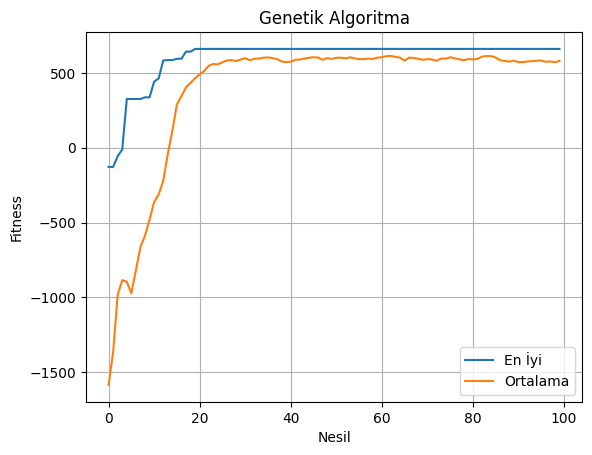

In [56]:
# Çıktılar
print(f"--- Simülasyon Sonu (Nesil: {NESIL_SAYISI}) ---")
if en_iyi_ind is not None:
    print(f"En İyi Sonuç: {en_iyi:.4f}")
    print(f"x1: {en_iyi_ind[0]:.4f}")
    print(f"x2: {en_iyi_ind[1]:.4f}")
    print(f"Toplam (x1+x2): {np.sum(en_iyi_ind):.2f}")

plt.plot(en_iyiler, label="En İyi")
plt.plot(ortalamalar, label="Ortalama")
plt.legend()
plt.title("Genetik Algoritma")
plt.xlabel("Nesil")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

# Simülasyon Sonuçları ve Yorumlar

### 1. Grafiğin Değerlendirilmesi
Oluşturulan fitness grafiği incelendiğinde algoritmanın davranışı hakkında şu gözlemler yapılabilir:

* **Hızlı Çözüm (Mavi Çizgi):** "En İyi Fitness" değeri simülasyonun başında hızla artış göstermiş ve yaklaşık **15. nesilde** tavan puan olan **660.00**'a ulaşmıştır. Algoritma geri kalan nesiller boyunca bu skoru korumayı başarmıştır. Bu da kullandığımız **Rulet Tekerleği** seçim yönteminin ve **Elitizm** (en iyiyi saklama) taktiğinin işe yaradığını gösterir.
* **Ceza Etkisi (Turuncu Çizgi):** Ortalama puanların ilk başta **-1500** gibi çok düşük bir seviyeden başladığı görülüyor. Bunun temel sebebi, kodumuzda sınır dışına çıkanlara veya toplamı 140'ı geçenlere uyguladığımız yüksek ceza puanlarıdır. İlk popülasyon tamamen rastgele olduğu için çoğu birey bu cezalara yakalanmıştır. Ancak nesiller ilerledikçe algoritma "kurallara uymayı" öğrenmiş ve ortalama puan hızla yükselmiştir.

### 2. Sonuçların Sağlaması
Algoritmanın 100 nesil sonunda vardığı nokta şudur:
* **x1 (Süre):** 60.00
* **x2 (Sıcaklık):** 60.00
* **Elde Edilen Skor:** 660.00

Bu sonucun doğru olup olmadığını denklem üzerinden kontrol edebiliriz:
Verilen formülde ($y = 8x_1 + 3x_2 - x_1x_2 + x_1^2$) **$x_1^2$** terimi sonucu çok büyüttüğü için, sürenin ($x_1$) mümkün olan en büyük değerde (60) olması mantıklıdır.
Aynı şekilde **$-x_1x_2$** terimi sonucu küçülttüğü için, sıcaklığın ($x_2$) mümkün olan en küçük değerde (60) olması gerekir.

**Matematiksel Hesap:**
$$Sonuç = 8(60) + 3(60) - (60 \times 60) + 60^2$$
$$Sonuç = 480 + 180 - 3600 + 3600 = \mathbf{660}$$

Elde edilen sonuç, hem matematiksel maksimumu vermekte hem de $60+60=120 \le 140$ kısıtını sağlamaktadır.